In [29]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

from pyspark.sql.functions import col
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import VectorAssembler, MinMaxScaler

from pyspark.ml.stat import Correlation
import pyspark.sql.functions as F

from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, LogisticRegression, LinearSVC, MultilayerPerceptronClassifier, GBTClassifier
from pyspark.ml.feature import PolynomialExpansion

In [ ]:
# Get the spark session
spark = SparkSession.builder.appName("Diabetes").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

##Data Loader


In [2]:
# Mount the drive unit (ignore if you are working in local)

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
dataset_folder = "/content/drive/MyDrive/Colab Notebooks/BigData/archive/"  # CHANGE HERE THE DATA FOLDER

df1 = spark.read.csv(dataset_folder + "diabetes_binary_5050split_health_indicators_BRFSS2015.csv", header =True)

In [4]:
#Summary stats
df1.show()

+---------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|Diabetes_binary|HighBP|HighChol|CholCheck| BMI|Smoker|Stroke|HeartDiseaseorAttack|PhysActivity|Fruits|Veggies|HvyAlcoholConsump|AnyHealthcare|NoDocbcCost|GenHlth|MentHlth|PhysHlth|DiffWalk|Sex| Age|Education|Income|
+---------------+------+--------+---------+----+------+------+--------------------+------------+------+-------+-----------------+-------------+-----------+-------+--------+--------+--------+---+----+---------+------+
|            0.0|   1.0|     0.0|      1.0|26.0|   0.0|   0.0|                 0.0|         1.0|   0.0|    1.0|              0.0|          1.0|        0.0|    3.0|     5.0|    30.0|     0.0|1.0| 4.0|      6.0|   8.0|
|            0.0|   1.0|     1.0|      1.0|26.0|   1.0|   1.0|                 0.0|         0.0|   1.0|    0.0|              0.0|   

In [5]:
#Viewing the dataframe schema
df1.printSchema()

root
 |-- Diabetes_binary: string (nullable = true)
 |-- HighBP: string (nullable = true)
 |-- HighChol: string (nullable = true)
 |-- CholCheck: string (nullable = true)
 |-- BMI: string (nullable = true)
 |-- Smoker: string (nullable = true)
 |-- Stroke: string (nullable = true)
 |-- HeartDiseaseorAttack: string (nullable = true)
 |-- PhysActivity: string (nullable = true)
 |-- Fruits: string (nullable = true)
 |-- Veggies: string (nullable = true)
 |-- HvyAlcoholConsump: string (nullable = true)
 |-- AnyHealthcare: string (nullable = true)
 |-- NoDocbcCost: string (nullable = true)
 |-- GenHlth: string (nullable = true)
 |-- MentHlth: string (nullable = true)
 |-- PhysHlth: string (nullable = true)
 |-- DiffWalk: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Education: string (nullable = true)
 |-- Income: string (nullable = true)



##Data visualization and preprocessing




In [6]:
# List of column names in the DataFrame
column_names = df1.columns


# Iterate over the columns and cast each one from string to int
for column_name in column_names:
    df1 = df1.withColumn(column_name, col(column_name).cast("int"))

In [7]:
#Viewing the dataframe schema
df1.printSchema()

root
 |-- Diabetes_binary: integer (nullable = true)
 |-- HighBP: integer (nullable = true)
 |-- HighChol: integer (nullable = true)
 |-- CholCheck: integer (nullable = true)
 |-- BMI: integer (nullable = true)
 |-- Smoker: integer (nullable = true)
 |-- Stroke: integer (nullable = true)
 |-- HeartDiseaseorAttack: integer (nullable = true)
 |-- PhysActivity: integer (nullable = true)
 |-- Fruits: integer (nullable = true)
 |-- Veggies: integer (nullable = true)
 |-- HvyAlcoholConsump: integer (nullable = true)
 |-- AnyHealthcare: integer (nullable = true)
 |-- NoDocbcCost: integer (nullable = true)
 |-- GenHlth: integer (nullable = true)
 |-- MentHlth: integer (nullable = true)
 |-- PhysHlth: integer (nullable = true)
 |-- DiffWalk: integer (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- Income: integer (nullable = true)



In [8]:
#Summary stats
df1.describe().show()

+-------+------------------+-------------------+------------------+-------------------+------------------+------------------+-------------------+--------------------+------------------+------------------+------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+-------------------+------------------+------------------+------------------+------------------+
|summary|   Diabetes_binary|             HighBP|          HighChol|          CholCheck|               BMI|            Smoker|             Stroke|HeartDiseaseorAttack|      PhysActivity|            Fruits|           Veggies|  HvyAlcoholConsump|      AnyHealthcare|        NoDocbcCost|           GenHlth|          MentHlth|          PhysHlth|           DiffWalk|               Sex|               Age|         Education|            Income|
+-------+------------------+-------------------+------------------+-------------------+------------------+------------------+-

I observe that there are no missing values, as indicated by the consistent count of 70692 for all columns. This eliminates the need to spend time addressing missing data.

Cholesterol check (CholCheck), Stroke, HeartDiseaseorAttack, heavy drinker (HvyAlcoholConsump), AnyHealthcare, NoDoctorCost, and DiffWalk are features having clear imbalanced results. With the exception of CholCheck and AnyHealthcare, which predominantly show positive responses (evident from a mean exceeding 0.95), the remaining variables tend to exhibit negative responses (indicated by a mean close to 0.1).

The BMI of the dataset is right-skewed. Most of the values are near from the mean 29, with extreme maximum value 98.

In [9]:
label_col = 'Diabetes_binary'

# Get all columns except the label column
all_columns = df1.columns
feature_columns = [col for col in all_columns if col != label_col]

# Assemble features into a vector column
assembler = VectorAssembler(inputCols=all_columns, outputCol="features")
df_assembled = assembler.transform(df1)

# Calculate the correlation matrix
corr_matrix = Correlation.corr(df_assembled, "features").head()

# Convert the correlation matrix to a Pandas DataFrame for better display
corr_df = pd.DataFrame(corr_matrix[0].toArray(), columns=all_columns, index=all_columns)

# Calculate the correlation between each feature and the label
label_correlation = {feature: df1.stat.corr(feature, label_col) for feature in all_columns}

# Display the correlation with the label
print("\nCorrelation with Label:")
for feature, correlation in label_correlation.items():
    print(f"{feature}: {correlation}")



Correlation with Label:
Diabetes_binary: 1.0
HighBP: 0.38151554890731115
HighChol: 0.2892128070886512
CholCheck: 0.1153816171027155
BMI: 0.293372744761032
Smoker: 0.08599896420800339
Stroke: 0.12542678468516716
HeartDiseaseorAttack: 0.2115234043602299
PhysActivity: -0.1586656048640533
Fruits: -0.05407655628666805
Veggies: -0.07929314561270084
HvyAlcoholConsump: -0.09485313995926573
AnyHealthcare: 0.023190748531130713
NoDocbcCost: 0.04097657326664344
GenHlth: 0.4076115984949162
MentHlth: 0.08702877147509427
PhysHlth: 0.21308101903810442
DiffWalk: 0.27264600615980633
Sex: 0.04441285837126153
Age: 0.27873806628189257
Education: -0.17048063498805865
Income: -0.22444871496381638


The correlation list with labels highlights that the features 'Smoker', 'Fruits', 'Veggies', 'AnyHealthcare', and 'Sex' exhibit low correlation with the label 'Diabetes_binary'. Consequently, I have opted to remove them from consideration

In [10]:
columns_to_drop = ['Smoker', 'Fruits', 'Veggies', 'AnyHealthcare', 'Sex']
df1 = df1.drop(*columns_to_drop)

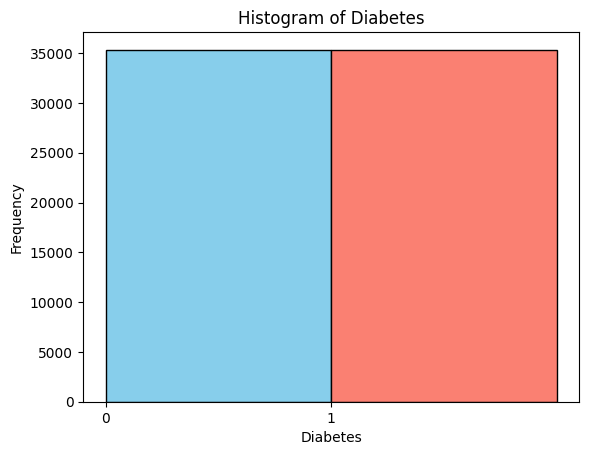

In [11]:
# Extract data from the "Diabetes_012" column
data = df1.select("Diabetes_binary").rdd.flatMap(lambda x: x).collect()

# Specify the colors for each bar
colors = ['skyblue', 'salmon']

bins = [0,1,2]

# Plot histogram with individually colored bars
n, bins, patches = plt.hist(data, bins=bins, edgecolor='black')

# Set colors for each bar individually
for i in range(len(patches)):
    patches[i].set_facecolor(colors[i])

plt.xlabel("Diabetes")
plt.ylabel("Frequency")
plt.title("Histogram of Diabetes")
plt.xticks(bins[:-1])  # Set x-axis ticks to match specified bins
plt.show()

0 is for no diabetes or only during pregnancy, 1 is for prediabetes and diabetes. There is an equal 50-50 split of respondents with no diabetes and with either prediabetes or diabetes.

In [12]:
# Rimuovi 'Diabetes_012' dalla lista di feature
feature_cols = [colonna for colonna in df1.columns if colonna != 'Diabetes_binary']

assembler = VectorAssembler(inputCols=feature_cols, outputCol='features1') # Assembler for the feature columns

scaler = MinMaxScaler(inputCol="features1", outputCol="features")

One method to standardize the input features is through the Min-Max scaler. This process transforms all features to the interval [0,1], ensuring that the minimum and maximum values of a feature fall within this range. By employing this scaling technique, variables with disparate scales won't exert disproportionate influence on model fitting and the learned function. This normalization is particularly beneficial for columns like 'BMI', 'MentHlth', and 'PhysHlth', where the values significantly exceed those in other attributes. This standardization improve specially the Naive Bayes classifier because

In [13]:
# Create the pipeline with the stages followed by the data.
pipeline = Pipeline(stages=[assembler, scaler])

# Fit pipeline model and transform data
df1 = pipeline.fit(df1).transform(df1)

##ML MODELS

For this classification task I decided to develop the following ML models:
1. Decision tree
2. Random Forest
3. Naive Bayes
4. Multilayer Perceptron
5. Logistic Regression
6. Support Vector Machine
7. Gradient Boosted Trees
8. Polynomial regression


In [14]:
# Split the data into train and test
train_data, test_data = df1.randomSplit([0.75, 0.25], seed=23)

In [16]:
# Decision Tree
dt = DecisionTreeClassifier(featuresCol='features', labelCol='Diabetes_binary', seed=23)

dt_model = dt.fit(train_data)

In [17]:
# Random Forest
rf = RandomForestClassifier(featuresCol='features', labelCol='Diabetes_binary', seed=23)

rf_model = rf.fit(train_data)

In [18]:
# Naive Bayes
nb = NaiveBayes(featuresCol='features', labelCol='Diabetes_binary', smoothing=0.3, modelType="multinomial")

nb_model = nb.fit(train_data)

In [20]:
# Multilayer Perceptron
mlp = MultilayerPerceptronClassifier(layers=[16, 32, 64, 2], maxIter=20,
                                     featuresCol='features', labelCol='Diabetes_binary', seed=23)

mlp_model = mlp.fit(train_data)

In [21]:
# Logistic regression
lr = LogisticRegression(featuresCol='features', labelCol='Diabetes_binary', maxIter=20, regParam=0.01)

lr_model = lr.fit(train_data)

In [22]:
svc = LinearSVC(featuresCol='features', labelCol='Diabetes_binary')

svc_model = svc.fit(train_data)

In [23]:
# Decision Tree
gbt = GBTClassifier(featuresCol='features', labelCol='Diabetes_binary', seed=23, maxIter=10)

gbt_model = gbt.fit(train_data)

In [24]:
class PolynomialLogisticRegression:
  def __init__(self, featuresCol, labelCol, spark , degree):
    self.spark = spark
    self.degree = degree
    self.featuresCol = featuresCol
    self.labelCol = labelCol
    self.fit = None
    self.poly_expansion = PolynomialExpansion(degree=degree, inputCol=featuresCol, outputCol="poly_features")

  def fit_(self,data):
    # Create a PolynomialExpansion transformer to generate polynomial features
    train_poly = self.poly_expansion.transform(data)
    reg = LogisticRegression(featuresCol='features', labelCol='Diabetes_binary', maxIter=10)
    self.fit= reg.fit(train_poly)
    return self

  def transform_(self,data):
    try:
      if(self.fit == None):
        raise "You should call the method fit() first"
      test_poly = self.poly_expansion.transform(data)
      preds = self.fit.transform(test_poly)
      return preds
    except Exception as e:
      print(e)

In [25]:
# Polynomial Logistic regression
plr = PolynomialLogisticRegression(featuresCol='features', labelCol='Diabetes_binary', spark = spark, degree = 3)

plr_model = plr.fit_(train_data)

##Evaluation Models

In [26]:
# Get the predictions from all the models for the test data
predictions_dt = dt_model.transform(test_data)
predictions_rf = rf_model.transform(test_data)
predictions_nb = nb_model.transform(test_data)
predictions_mlp = mlp_model.transform(test_data)
predictions_lr = lr_model.transform(test_data)
predictions_svc = svc_model.transform(test_data)
predictions_gbt = gbt_model.transform(test_data)
predictions_plr = plr_model.transform_(test_data)

# List with all predictions
predictions = [
    predictions_dt,
    predictions_rf,
    predictions_nb,
    predictions_mlp,
    predictions_lr,
    predictions_svc,
    predictions_gbt,
    predictions_plr
]

In [27]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd

# Create a dictionary to store results
detailed_results_dict = {"Classifier": [], "Accuracy": [], "Precision": [], "Recall": [], "F1 Score": []}

# Function to calculate precision, recall, and F1 score
def calculate_metrics(predictions):
    TP = predictions.filter("prediction = 1 AND Diabetes_binary = 1").count()
    FP = predictions.filter("prediction = 1 AND Diabetes_binary = 0").count()
    TN = predictions.filter("prediction = 0 AND Diabetes_binary = 0").count()
    FN = predictions.filter("prediction = 0 AND Diabetes_binary = 1").count()

    accuracy = (TP + TN) / (TP + FP + TN + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1_score

# Calculate metrics for each classifier
for i, prediction_df in enumerate(predictions):
    classifier_name = ["Decision Tree", 'Random Forest', 'Naive Bayes', 'Multi layer Perceptron', 'Logistic regression', 'Support Vector Machine', 'Gradient Boosted Trees', 'Polynomial Logistic regression'][i]
    accuracy, precision, recall, f1_score = calculate_metrics(prediction_df)

    # Append results to the dictionary
    detailed_results_dict["Classifier"].append(classifier_name)
    detailed_results_dict["Accuracy"].append(accuracy)
    detailed_results_dict["Precision"].append(precision)
    detailed_results_dict["Recall"].append(recall)
    detailed_results_dict["F1 Score"].append(f1_score)

# Convert results to a DataFrame
detailed_results_df = pd.DataFrame(detailed_results_dict)
detailed_results_df


,Classifier,Accuracy,Precision,Recall,F1 Score
0,Decision Tree,0.730752,0.712061,0.771934,0.740789
1,Random Forest,0.739452,0.723905,0.771477,0.746935
2,Naive Bayes,0.695496,0.722585,0.631489,0.673973
3,Multi layer Perceptron,0.738371,0.712232,0.797148,0.752301
4,Logistic regression,0.747299,0.740563,0.758813,0.749577
5,Support Vector Machine,0.745650,0.728055,0.781631,0.753893
6,Gradient Boosted Trees,0.742068,0.721948,0.784712,0.752023
7,Polynomial Logistic regression,0.746730,0.740328,0.757558,0.748844


The model with the best metric values is the logistic regression but a further analysis considering precision/recall metrics for each the two labels value is conducted below.
*  Accuracy: the ratio of correctly predicted instances to the total instances. It provides an overall measure of how well the model is performing. However, it may not be suitable for imbalanced datasets.
*   Precision: the ratio of correctly predicted positive observations to the total predicted positives. It measures the accuracy of the positive predictions. A high precision indicates that the model has fewer false positives.
*   Recall (Sensitivity or True Positive Rate): the ratio of correctly predicted positive observations to the all observations in the actual class.
Interpretation: It measures the ability of the model to capture all the relevant instances of the positive class. A high recall indicates that the model can identify most of the positive instances.
*   F1 Score: the weighted average of precision and recall. It combines precision and recall into a single metric. It is useful when there is an uneven class distribution (imbalanced classes). It balances precision and recall, providing a single score that considers both false positives and false negatives.

In [28]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
from pyspark.sql import functions as F

# Assuming 'Diabetes_binary' is the label column and 'prediction' is the predicted label column
label_col = 'Diabetes_binary'
prediction_col = 'prediction'

# Create a dictionary to store results
detailed_results_dict1 = {"Classifier": [], "Precision_0": [], "Recall_0": [], "Precision_1": [], "Recall_1": []}

# Function to calculate metrics for each class
def calculate_metrics(predictions, class_value):
    TP = predictions.filter((F.col(prediction_col) == class_value) & (F.col(label_col) == class_value)).count()
    FP = predictions.filter((F.col(prediction_col) == class_value) & (F.col(label_col) != class_value)).count()
    TN = predictions.filter((F.col(prediction_col) != class_value) & (F.col(label_col) != class_value)).count()
    FN = predictions.filter((F.col(prediction_col) != class_value) & (F.col(label_col) == class_value)).count()

    precision = TP / (TP + FP) if (TP + FP) != 0 else 0
    recall = TP / (TP + FN) if (TP + FN) != 0 else 0

    return precision, recall

# Calculate metrics for each classifier and each class
for i, prediction_df in enumerate(predictions):
    classifier_name = ["Decision Tree", 'Random Forest', 'Naive Bayes', 'Multi-layer Perceptron', 'Logistic Regression', 'Support Vector Machine','Gradient Boosted Trees', 'Polynomial Logistic regression'][i]

    # Class 0
    precision_0, recall_0 = calculate_metrics(prediction_df, 0)

    # Class 1
    precision_1, recall_1 = calculate_metrics(prediction_df, 1)

    # Append results to the dictionary
    detailed_results_dict1["Classifier"].append(classifier_name)
    detailed_results_dict1["Precision_0"].append(precision_0)
    detailed_results_dict1["Recall_0"].append(recall_0)
    detailed_results_dict1["Precision_1"].append(precision_1)
    detailed_results_dict1["Recall_1"].append(recall_1)

# Convert results to a DataFrame
detailed_results_df1 = pd.DataFrame(detailed_results_dict1)
detailed_results_df1


,Classifier,Precision_0,Recall_0,Precision_1,Recall_1
0,Decision Tree,0.752721,0.689831,0.712061,0.771934
1,Random Forest,0.757065,0.707630,0.723905,0.771477
2,Naive Bayes,0.674592,0.759098,0.722585,0.631489
3,Multi-layer Perceptron,0.771348,0.679968,0.712232,0.797148
4,Logistic Regression,0.754329,0.735858,0.740563,0.758813
5,Support Vector Machine,0.765900,0.709897,0.728055,0.781631
6,Gradient Boosted Trees,0.765852,0.699694,0.721948,0.784712
7,Polynomial Logistic regression,0.753394,0.735971,0.740328,0.757558


In a binary classification task where the goal is to identify whether a person has diabetes or not (with 1 indicating diabetes), precision and recall values for each class can be interpreted as follows:

*  Precision_class_0: This represents the precision for the class labeled as 0, which corresponds to the negative class (no diabetes). It indicates the proportion of correctly predicted instances of no diabetes among all instances predicted as no diabetes. In other words, it measures how many of the instances predicted as no diabetes are actually no diabetes.
*  Recall_class_0: This represents the recall (or sensitivity) for the class labeled as 0, which again corresponds to the negative class (no diabetes). It indicates the proportion of correctly predicted instances of no diabetes among all instances that are actually no diabetes. In other words, it measures how many of the actual instances of no diabetes were correctly identified by the model.
*  Precision_class_1: This represents the precision for the class labeled as 1, which corresponds to the positive class (diabetes). It indicates the proportion of correctly predicted instances of diabetes among all instances predicted as diabetes. In other words, it measures how many of the instances predicted as diabetes are actually diabetes.
*  Recall_class_1: This represents the recall (or sensitivity) for the class labeled as 1, which again corresponds to the positive class (diabetes). It indicates the proportion of correctly predicted instances of diabetes among all instances that are actually diabetes. In other words, it measures how many of the actual instances of diabetes were correctly identified by the model.

In the context of identifying diabetes, a high precision means that when the model predicts an individual has diabetes, it is likely correct. A high recall means that the model is good at capturing most of the individuals who actually have diabetes.

The model with the best precision for class 0 is the Multilayer Perceptron \\
The model with the best precision for class 1 is the Logistic Regression \\
The model with the best recall for class 0 is the Naive Bayes \\
The model with the best recall for class 1 is the Multilayer Perceptron \\

In summary, the Multilayer Perceptron (MLP) stands out for its high recall in identifying individuals with diabetes, suggesting it's good at capturing most diabetes cases, while also exhibiting high precision for class 0 (non-diabetes), indicating it's reliable in identifying individuals without diabetes. Logistic Regression excels in precision for diabetes prediction, minimizing false alarms for positive cases. Naive Bayes performs well in recalling individuals without diabetes, ensuring most non-diabetic cases are correctly identified.